(ads-sparc)=
# Adsorption energy from DFT

## Adsorption Energy
- Adsorption energy refers to the change of energy when an adsorbate is attached to the surface of an adsorbent. 
- Adsorption energy, ${\Delta}E_{a}$, can be obtained by calculating the difference between the energy of the adsorbed surface and the sum of the energy for each structure composing the adsorbed surface:
<br> ${\Delta}E_{a} =  E_{ads,slab} -  E_{slab} - E_{ads}$



## Calculating Adsorption Energy in SPARC

Consider O<sub>2</sub> adsorption on Platinum (Pt) surface with constrained atom positions. For this situation, we will first build the Atoms object for Platinum slab and adsorb an oxygen molecule to the slab.

**Building atoms**

* In the following script, a Pt slab is created. The bottom two layers of Pt (in z-direction) are fixed. The exact position to divide the atoms is determined by visualizing the ‘input.traj’ file with ase gui command. By clicking on the atoms in the pop-out window, the exact position within a cell will be displayed. After applying the constraint to the system, visualizing ‘input.traj’ file with ase gui command, you should be able to see the bottom two layers of Pt atoms have a cross on them, indicating that they are fixed. Another way to check or to manipulate the constraint is by ‘POSCAR’, where it lists the positions and constraints of all atoms in the system.

In [5]:
from ase.build import bulk, molecule, surface, add_adsorbate, fcc111, fcc100
from ase.constraints import FixAtoms
from ase.io import read

#building Platinum slab

bulk = bulk('Pt')
miller_indices = (1, 1, 1)
layers = 3
slab = surface (bulk , indices = miller_indices , layers = layers , vacuum =10)
slab = slab.repeat((1,1,1))

c = FixAtoms ( indices = [ atom.index for atom in slab if atom.position [2] <14 ]) #constrained atoms (fixing the bottom 2 layers)
slab.set_constraint(c)
slab.write('slab.traj')

* There is another way to generate surfaces.

Two surfaces are identical.


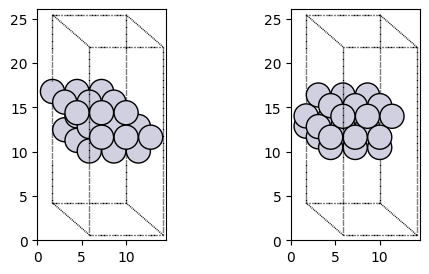

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from ase.visualize.plot import plot_atoms

slab_fcc111 = fcc111('Pt', size=(1,1,3), vacuum=10)

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
plot_atoms(slab.repeat([3,3,1]), axs[0], rotation=('120x,0y,0z'))
plot_atoms(slab_fcc111.repeat([3,3,1]), axs[1], rotation=('120x,0y,0z'))

slab.write('POSCAR_1')
slab_fcc111.write('POSCAR_2')

if np.all(slab.get_all_distances(mic=True) == slab_fcc111.get_all_distances(mic=True)):
    print("Two surfaces are identical.")


- Build an O<sub>2</sub> molecule with ase library.

In [10]:
from ase.build import molecule, bulk
import numpy as np
from shutil import copy
import os

#building oxygen molecule

atoms = molecule('O2')
max_pos = np.amax(atoms.get_positions(), axis=0)
atoms.set_cell(np.array([10, 10, 10]) + max_pos)
atoms.center()

atoms.write('O2.traj')

- Attach the O<sub>2</sub> to the Pt slab using ase.build.add_adsorbate().

In [11]:
from ase.build import bulk, molecule, surface, add_adsorbate
from ase.constraints import FixAtoms
from ase.io import read

slab = read('slab.traj')
adsorbate = molecule('O2')
add_adsorbate(slab, adsorbate, height = 2.5, position = (1.386, 0.800) )
c = FixAtoms ( indices = [ atom.index for atom in slab if atom.position [2] <14 ]) #constrained atoms (fixing the bottom 2 layers)
slab.set_constraint(c)
slab.write('slab_ads.traj')

**DFT calculation**
- In the following script, we define a SPARC calculator object and attach it to an ase.Atoms object so that ase knows how to get the data. After defining the calculator, a DFT calculation can be run. The potential energy can be obtained by the method: get_potential_energy(). The potential energy result can be stored in a text file e.g. 'energy.txt'.
- Details on how to submit these calculations can be seen in Lecture 'Running_SPARC_on_PACE'.

1. Clean slab calculation

In [12]:
from ase.io import read
from ase.optimize import BFGSLineSearch 
from ase.units import Bohr,Hartree,mol,kcal,kJ,eV
from sparc import SPARC
import numpy as np

image = read('slab.traj')

# Setting up calculator.
# Here, we set relatively low values for KPOINT_GRID and ECUT, and did not apply spin-polarization
# so that we can finish the calculations faster. This can lead to unreasonable energy values.
 
parameters = dict(
                EXCHANGE_CORRELATION = 'GGA_PBE',
                D3_FLAG=1,   #Grimme D3 dispersion correction
                SPIN_TYP=0,   #non spin-polarized calculation
                KPOINT_GRID=[2,2,1],  #slab needs only 1 kpt in z-direction 
                ECUT=500/Hartree,   #set ECUT (Hartree) or h (Angstrom)
                #h = 0.15,
                TOL_SCF=1e-4,
                RELAX_FLAG=1,   #Do structural relaxation (only atomic positions)
                TOL_RELAX = 1.00E-03,  #convergence criteria (maximum force) (Ha/Bohr)
                PRINT_FORCES=1,
                PRINT_RELAXOUT=1)

parameters['directory'] = 'slab'

calc = SPARC(atoms = image, **parameters)
image.set_calculator(calc)

eng = image.get_potential_energy()

image.write('converged_slab.traj')

with open('slab_energy.txt', 'w') as f:
    f.write(str(eng))


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
{0: array([False, False, False]), 1: array([False, False, False]), 2: array([ True,  True,  True])}
[0, 1, 2] [0, 1, 2]


2. O<sub>2</sub> on the Pt slab

In [13]:
from ase.io import read
from ase.optimize import BFGSLineSearch 
from ase.units import Bohr,Hartree,mol,kcal,kJ,eV
from sparc import SPARC
import numpy as np

image = read('slab_ads.traj')

# setup calculator
parameters = dict(
                EXCHANGE_CORRELATION = 'GGA_PBE',
                D3_FLAG=1,   #Grimme D3 dispersion correction
                SPIN_TYP=0,   #non spin-polarized calculation
                KPOINT_GRID=[2,2,1],  #slab needs only 1 kpt in z-direction 
                ECUT=500/Hartree,   #set ECUT (Hartree) or h (Angstrom)
                #h = 0.15,
                TOL_SCF=1e-4,
                RELAX_FLAG=1,   #Do structural relaxation (only atomic positions)
                TOL_RELAX = 1.00E-03,  #convergence criteria (maximum force) (Ha/Bohr)
                PRINT_FORCES=1,
                PRINT_RELAXOUT=1)

parameters['directory'] = 'slab_ads'

calc = SPARC(atoms = image, **parameters)
image.set_calculator(calc)

eng = image.get_potential_energy()

image.write('converged_slab_ads.traj')

with open('slab_ads_energy.txt', 'w') as f:
    f.write(str(eng))


Step  0
Step  1
Step  2
Step  3
Step  4
Step  5
Step  6
Step  7
Step  8
Step  9
Step  10
Step  11
Step  12
Step  13
Step  14
Step  15
Step  16
Step  17
Step  18
Step  19
Step  20
Step  21
Step  22
Step  23
Step  24
Step  25
Step  26
Step  27
Step  28
Step  29
Step  30
Step  31
Step  32
Step  33
Step  34
Step  35
Step  36
Step  37
Step  38
Step  39
Step  40
Step  41
Step  42
Step  43
Step  44
Step  45
Step  46
Step  47
Step  48
Step  49
{0: array([ True,  True,  True]), 1: array([ True,  True,  True]), 2: array([False, False, False]), 3: array([False, False, False]), 4: array([ True,  True,  True])}
[2, 3, 4, 0, 1] [3, 4, 0, 1, 2]


3. O<sub>2</sub> gas reference energy calculation

In [14]:
from ase.io import read
from ase.optimize import BFGSLineSearch 
from ase.units import Bohr,Hartree,mol,kcal,kJ,eV
from sparc import SPARC
import numpy as np

image = read('O2.traj')

# setup calculator
parameters = dict(
                EXCHANGE_CORRELATION = 'GGA_PBE',
                D3_FLAG=1,   #Grimme D3 dispersion correction
                SPIN_TYP=0,   #non spin-polarized calculation
                KPOINT_GRID=[1,1,1],  #molecule needs single kpt !
                ECUT=500/Hartree,   #set ECUT (Hartree) or h (Angstrom)
                #h = 0.15,
                TOL_SCF=1e-4,
                RELAX_FLAG=1,   #Do structural relaxation (only atomic positions)
                TOL_RELAX = 1.00E-03,  #convergence criteria (maximum force) (Ha/Bohr)
                PRINT_FORCES=1,
                PRINT_RELAXOUT=1)

parameters['directory'] = 'O2'

calc = SPARC(atoms = image, **parameters)
image.set_calculator(calc)

eng = image.get_potential_energy()

image.write('converged_O2.traj')

with open('O2_energy.txt', 'w') as f:
    f.write(str(eng))


Step  0
Step  1
Step  2
Step  3
{}
[0, 1] [0, 1]


- Analysis of adsorption energies

In [15]:
import os
from ase.io import read

def readFile(path):
    f = open(path, 'r')
    content = f.readlines()
    return content

def read_energy(path):
    energy = float(readFile(path)[0])
    return energy

E_slab = read_energy('slab_energy.txt')
E_slab_ads = read_energy('slab_ads_energy.txt')
E_O2 = read_energy('O2_energy.txt')

# E_adsorption is the adsorption energy
E_adsorption = E_slab_ads - E_slab - E_O2

print('The adsorption energy of O2 on Pt slab is {0:1.3f} eV'.format(E_adsorption))


The adsorption energy of O2 on Pt slab is -0.831 eV
